In [2]:
import osmnx as ox #OSM
import json
from shapely.geometry import shape, GeometryCollection, Polygon
import geopandas as gpd

### 01-road-network

#### 1 Define ROI

##### 1a OSM-defined boundaries
The easiest way to pull a road network is to use `graph_from_place`, which assumes that OSM will recognize the ROI from the name of the place.
 - To find out whether or not OSM will have the boundary of the place, run the following cell and see if the ROI output is a point or a boundary.
    - For example, Chamoli will output a boundarary if we feed in `'Chamoli, India'`, but Dehradun will only output a point if we feed in `'Dehradun, India'`

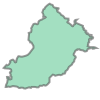

In [3]:
place_name = 'Rudraprayag, India'
place = ox.geocode_to_gdf(place_name)
place_roi = place.iloc[0,0]
place_roi

 - If the place exists as a boundary in OSM, you can retrieve the road network by using `graph_from_place` in Section 2

##### 1b Pulling from osm-boundaries.com
Sometimes OSM will not recognize the place as a boundary, but as a point, like in this example below:

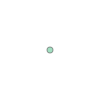

In [5]:
dehradun = ox.geocode_to_gdf('Dehradun, India')
dehradun.iloc[0,0]

 - To get boundaries, download them from [osm-boundaries.com](https://osm-boundaries.com/Map). You will need to make a Open Street Maps account first.
    - When downloading, leave all the default settings
 - Read GEOJSON using geopandas, from [this thread](https://stackoverflow.com/questions/42753745/how-can-i-parse-geojson-with-python).
 - Convert it to a shapely polygon using shape function, from [shapely docs](https://shapely.readthedocs.io/en/stable/manual.html#python-geo-interface).

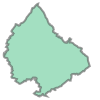

In [30]:
roi_file = gpd.read_file('haridwar.geojson')
roi = roi_file['geometry'].iloc[0]
roi_shape = shape(roi)
roi_shape

 - Then use `graph_from_polygon` in Section 2.

#### 2 Retrieve Road Network
 - Information on `graph_from` functions from [OSMnx developer article](https://geoffboeing.com/2016/11/osmnx-python-street-networks/). Additional help from [OSMnx docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_polygon).
 - `network_type="all"` to include all roads
 
##### 2a From Place

In [4]:
G = ox.graph_from_place('Uttarakhand, India', network_type='all')

##### 2b From Polygon

In [31]:
G = ox.graph_from_polygon(roi_shape, network_type='all')

#### 3 Project and Save Network

- For the analyses, the map projection needs to be in meters, rather than degrees. Use `project_graph` to convert the graph to its relevant UTM projection ([docs here](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.projection.project_graph))

In [32]:
G_proj = ox.project_graph(G)

 - Save the road network as a geopackage, so it can be dumped into QGIS

In [5]:
ox.save_graph_geopackage(G, filepath="roads-uttarakhand.gpkg")

### Appendix

##### A3 Boundary Box

#### B Complex Network Functions

##### B1 Using `simplify=False`

 - `simplify=False` to pull the road network in smaller segments, taken from [this thread](https://stackoverflow.com/questions/62440539/dividing-streets-to-smaller-segments-in-osmnx). This is to increase the granularity of our road network, making closure predictions more useful (ie. it is more useful to know which specific section of a road will close, rather than the entire, long road)
 - However, pulling roads that are too small is not helpful either ('roads' become step-sized), which is why the main script uses `simplify=True`. Afterwards, user breaks roads down manually in QGIS.

##### B2 Consolidating intersections

Original thought process:
- Some road segments will be too short (ie. less than 100 meters), so use `consolidate_intersections` to merge segments ([docs here](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.simplification.consolidate_intersections))
 - The trickiest part is setting the tolerance
     - Setting tolerance to 1000 will consolidate all nodes into 1 node, erases road network
     - Tolerance = 15 restarts the kernel

Later realized that `consolidate_intersections` does not retain the original road network but draws new straight lines between nodes, so not helpful for this analysis.

In [ ]:
G_proj_cons = ox.consolidate_intersections(G_proj, 15)